<a href="https://colab.research.google.com/github/maurovil/mustached-octo-happiness/blob/master/01_neural_network_regression_in_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 01. Neural Network Regression with TensorFlow

There are many definitions for a [regression problem](https://en.wikipedia.org/wiki/Regression_analysis) but in our case, we're going to simplify it to be: predicting a number.

For example, you might want to:
- Predict the selling price of houses given information about them (such as number of rooms, size, number of bathrooms).
- Predict the coordinates of a bounding box of an item in an image.
- Predict the cost of medical insurance for an individual given their demographics (age, sex, gender, race).

In this notebook, we're going to set the foundations for how you can take a sample of inputs (this is your data), build a neural network to discover patterns in those inputs and then make a prediction (in the form of a number) based on those inputs.

## What we're going to cover

Specifically, we're going to go through doing the following with TensorFlow:
- Architecture of a regression model
- Input shapes and output shapes
  - `X`: features/data (inputs)
  - `y`: labels (outputs)
- Creating custom data to view and fit
- Steps in modelling
  - Creating a model
  - Compiling a model
    - Defining a loss function
    - Setting up an optimizer
    - Creating evaluation metrics
  - Fitting a model (getting it to find patterns in our data)
- Evaluating a model
  - Visualizng the model ("visualize, visualize, visualize")
  - Looking at training curves
  - Compare predictions to ground truth (using our evaluation metrics)
- Saving a model (so we can use it later)
- Loading a model

Don't worry if none of these make sense now, we're going to go through each.

## How you can use this notebook

You can read through the descriptions and the code (it should all run), but there's a better option.

Write all of the code yourself.

Yes. I'm serious. Create a new notebook, and rewrite each line by yourself. Investigate it, see if you can break it, why does it break?

You don't have to write the text descriptions but writing the code yourself is a great way to get hands-on experience.

Don't worry if you make mistakes, we all do. The way to get better and make less mistakes is to **write more code**.

## Typical architecture of a regresison neural network

The word *typical* is on purpose.

Why?

Because there are many different ways (actually, there's almost an infinite number of ways) to write neural networks.

But the following is a generic setup for ingesting a collection of numbers, finding patterns in them and then outputting some kind of target number.

Yes, the previous sentence is vague but we'll see this in action shortly.

| **Hyperparameter** | **Typical value** |
| --- | --- |
| Input layer shape | Same shape as number of features (e.g. 3 for # bedrooms, # bathrooms, # car spaces in housing price prediction) |
| Hidden layer(s) | Problem specific, minimum = 1, maximum = unlimited |
| Neurons per hidden layer | Problem specific, generally 10 to 100 |
| Output layer shape | Same shape as desired prediction shape (e.g. 1 for house price) |
| Hidden activation | Usually [ReLU](https://www.kaggle.com/dansbecker/rectified-linear-units-relu-in-deep-learning) (rectified linear unit) |
| Output activation | None, ReLU, logistic/tanh |
| Loss function | [MSE](https://en.wikipedia.org/wiki/Mean_squared_error) (mean square error) or [MAE](https://en.wikipedia.org/wiki/Mean_absolute_error) (mean absolute error)/Huber (combination of MAE/MSE) if outliers |
| Optimizer | [SGD](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) (stochastic gradient descent), [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) |

*Table 1: Typical architecture of a regression network. Source: Adapted from page 293 of [Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow Book by Aurélien Géron](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)*

Again, if you're new to neural networks and deep learning in general, much of the above table won't make sense. But don't worry, we'll be getting hands-on with all of it soon.

> 🔑 **Note:** A **hyperparameter** in machine learning is something a data analyst or developer can set themselves, where as a **parameter** usually describes something a model learns on its own (a value not explicitly set by an analyst).

Okay, enough talk, let's get started writing code.

To use TensorFlow, we'll import it as the common alias `tf` (short for TensorFlow).

## A larger example

Alright, we've seen the fundamentals of building neural network regression models in TensorFlow.

Let's step it up a notch and build a model for a more feature rich dataset.

More specifically we're going to try predict the cost of medical insurance for individuals based on a number of different parameters such as, `age`, `sex`, `bmi`, `children`, `smoking_status` and `residential_region`.

To do, we'll leverage the pubically available [Medical Cost dataset](https://www.kaggle.com/mirichoi0218/insurance) available from Kaggle and [hosted on GitHub](https://github.com/stedy/Machine-Learning-with-R-datasets/blob/master/insurance.csv).

> 🔑 **Note:** When learning machine learning paradigms, you'll often go through a series of foundational techniques and then practice them by working with open-source datasets and examples. Just as we're doing now, learn foundations, put them to work with different problems. Every time you work on something new, it's a good idea to search for something like "problem X example with Python/TensorFlow" where you substitute X for your problem.

In [ ]:
# Import required libraries
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Read in the insurance dataset
insurance = pd.read_csv("https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv")

In [ ]:
# Check out the insurance dataset
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


We're going to have to turn the non-numerical columns into numbers (because a neural network can't handle non-numerical inputs).

To do so, we'll use the [`get_dummies()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) method in pandas.

It converts categorical variables (like the `sex`, `smoker` and `region` columns) into numerical variables using one-hot encoding.

In [ ]:
# Turn all categories into numbers
insurance_one_hot = pd.get_dummies(insurance)
insurance_one_hot.head() # view the converted columns

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,1,0,0,1,0,0,0,1
1,18,33.770,1,1725.55230,0,1,1,0,0,0,1,0
2,28,33.000,3,4449.46200,0,1,1,0,0,0,1,0
3,33,22.705,0,21984.47061,0,1,1,0,0,1,0,0
4,32,28.880,0,3866.85520,0,1,1,0,0,1,0,0


Now we'll split data into features (`X`) and labels (`y`).

In [ ]:
# Create X & y values
X = insurance_one_hot.drop("charges", axis=1)
y = insurance_one_hot["charges"]

In [ ]:
# View features
X.head()

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,1,0,0,1,0,0,0,1
1,18,33.770,1,0,1,1,0,0,0,1,0
2,28,33.000,3,0,1,1,0,0,0,1,0
3,33,22.705,0,0,1,1,0,0,1,0,0
4,32,28.880,0,0,1,1,0,0,1,0,0


And create training and test sets. We could do this manually, but to make it easier, we'll leverage the already available [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function available from Scikit-Learn.

In [ ]:
# Create training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42) # set random state for reproducible splits

Now we can build and fit a model (we'll make it the same as `model_2`).

In [ ]:
# Set random seed
tf.random.set_seed(42)

# Create a new model (same as model_2)
insurance_model = tf.keras.Sequential([
  tf.keras.layers.Dense(1),
  tf.keras.layers.Dense(1)
])

# Compile the model
insurance_model.compile(loss=tf.keras.losses.mae,
                        optimizer=tf.keras.optimizers.SGD(),
                        metrics=['mae'])

# Fit the model
insurance_model.fit(X_train, y_train, epochs=100)

Epoch 1/100
34/34 [==============================] - 1s 3ms/step - loss: 9369.4971 - mae: 9369.4971
Epoch 2/100
34/34 [==============================] - 0s 3ms/step - loss: 7851.0615 - mae: 7851.0615
Epoch 3/100
34/34 [==============================] - 0s 3ms/step - loss: 7567.6006 - mae: 7567.6006
Epoch 4/100
34/34 [==============================] - 0s 3ms/step - loss: 7540.6812 - mae: 7540.6812
Epoch 5/100
34/34 [==============================] - 0s 3ms/step - loss: 7695.3062 - mae: 7695.3062
Epoch 6/100
34/34 [==============================] - 0s 3ms/step - loss: 7608.9712 - mae: 7608.9712
Epoch 7/100
34/34 [==============================] - 0s 3ms/step - loss: 7517.2896 - mae: 7517.2896
Epoch 8/100
34/34 [==============================] - 0s 3ms/step - loss: 7788.9150 - mae: 7788.9150
Epoch 9/100
34/34 [==============================] - 0s 3ms/step - loss: 7584.7583 - mae: 7584.7583
Epoch 10/100
34/34 [==============================] - 0s 3ms/step - loss: 7721.3062 - mae: 7721.3062

In [ ]:
# Check the results of the insurance model
insurance_model.evaluate(X_test, y_test)

9/9 [==============================] - 0s 2ms/step - loss: 6392.2939 - mae: 6392.2939


[6392.2939453125, 6392.2939453125]

Our model didn't perform very well, let's try a bigger model.

We'll try 3 things:
- Increasing the number of layers (2 -> 3).
- Increasing the number of units in each layer (except for the output layer).
- Changing the optimizer (from SGD to Adam).

Everything else will stay the same.

In [ ]:
# Set random seed
tf.random.set_seed(42)

# Add an extra layer and increase number of units
insurance_model_2 = tf.keras.Sequential([
  tf.keras.layers.Dense(100), # 100 units
  tf.keras.layers.Dense(10), # 10 units
  tf.keras.layers.Dense(1) # 1 unit (important for output layer)
])

# Compile the model
insurance_model_2.compile(loss=tf.keras.losses.mae,
                          optimizer=tf.keras.optimizers.Adam(), # Adam works but SGD doesn't
                          metrics=['mae'])

# Fit the model and save the history (we can plot this)
history = insurance_model_2.fit(X_train, y_train, epochs=100, verbose=0)

In [ ]:
# Evaluate our larger model
insurance_model_2.evaluate(X_test, y_test)

9/9 [==============================] - 0s 2ms/step - loss: 4629.1626 - mae: 4629.1626


[4629.16259765625, 4629.16259765625]

Much better! Using a larger model and the Adam optimizer results in almost half the error as the previous model.

> 🔑 **Note:** For many problems, the [Adam optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) is a great starting choice. See Andrei Karpathy's "Adam is safe" point from [*A Recipe for Training Neural Networks*](http://karpathy.github.io/2019/04/25/recipe/) for more.

Let's check out the loss curves of our model, we should see a downward trend.

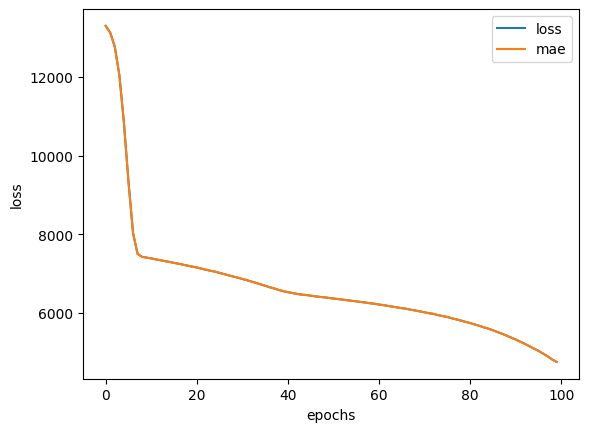

In [ ]:
# Plot history (also known as a loss curve)
pd.DataFrame(history.history).plot()
plt.ylabel("loss")
plt.xlabel("epochs");

From this, it looks like our model's loss (and MAE) were both still decreasing (in our case, MAE and loss are the same, hence the lines in the plot overlap eachother).

What this tells us is the loss might go down if we try training it for longer.

> 🤔 **Question:** How long should you train for?

> It depends on what problem you're working on. Sometimes training won't take very long, other times it'll take longer than you expect. A common method is to set your model training for a very long time (e.g. 1000's of epochs) but set it up with an [EarlyStopping callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) so it stops automatically when it stops improving. We'll see this in another module.

Let's train the same model as above for a little longer. We can do this but calling fit on it again.

In [ ]:
# Try training for a little longer (100 more epochs)
history_2 = insurance_model_2.fit(X_train, y_train, epochs=100, verbose=0)

How did the extra training go?

In [ ]:
# Evaluate the model trained for 200 total epochs
insurance_model_2_loss, insurance_model_2_mae = insurance_model_2.evaluate(X_test, y_test)
insurance_model_2_loss, insurance_model_2_mae

9/9 [==============================] - 0s 3ms/step - loss: 3483.4031 - mae: 3483.4031


(3483.403076171875, 3483.403076171875)

Boom! Training for an extra 100 epochs we see about a 10% decrease in error.

How does the visual look?

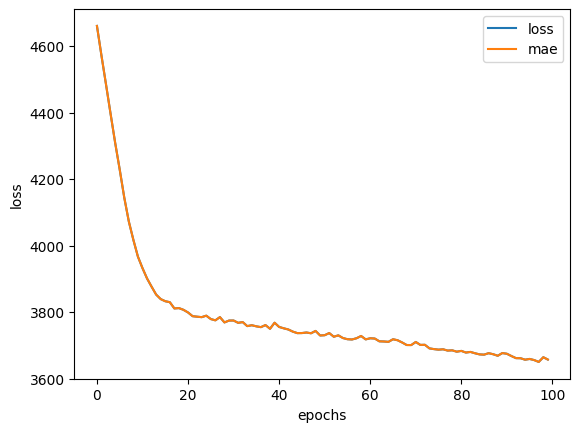

In [ ]:
# Plot the model trained for 200 total epochs loss curves
pd.DataFrame(history_2.history).plot()
plt.ylabel("loss")
plt.xlabel("epochs"); # note: epochs will only show 100 since we overrid the history variable

## Preprocessing data (normalization and standardization)

A common practice when working with neural networks is to make sure all of the data you pass to them is in the range 0 to 1.

This practice is called **normalization** (scaling all values from their original range to, e.g. between 0 and 100,000 to be between 0 and 1).

There is another process call **standardization** which converts all of your data to unit variance and 0 mean.

These two practices are often part of a preprocessing pipeline (a series of functions to prepare your data for use with neural networks).

Knowing this, some of the major steps you'll take to preprocess your data for a neural network include:
* Turning all of your data to numbers (a neural network can't handle strings).
* Making sure your data is in the right shape (verifying input and output shapes).
* [**Feature scaling**](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-scaler):
    * Normalizing data (making sure all values are between 0 and 1). This is done by subtracting the minimum value then dividing by the maximum value minus the minimum. This is also referred to as min-max scaling.
    * Standardization (making sure all values have a mean of 0 and a variance of 1). This is done by subtracting the mean value from the target feature and then dividing it by the standard deviation.
    * Which one should you use?
      * **With neural networks you'll tend to favour normalization** as they tend to prefer values between 0 and 1 (you'll see this espcially with image processing), however, you'll often find a neural network can perform pretty well with minimal feature scaling.

> 📖 **Resource:** For more on preprocessing data, I'd recommend reading the following resources:
* [Scikit-Learn's documentation on preprocessing data](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-data).
* [Scale, Standardize or Normalize with Scikit-Learn by Jeff Hale](https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02).

We've already turned our data into numbers using `get_dummies()`, let's see how we'd normalize it as well.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

# Read in the insurance dataset
insurance = pd.read_csv("https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv")

In [ ]:
# Check out the data
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Now, just as before, we need to transform the non-numerical columns into numbers and this time we'll also be normalizing the numerical columns with different ranges (to make sure they're all between 0 and 1).

To do this, we're going to use a few classes from Scikit-Learn:
* [`make_column_transformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_transformer.html) - build a multi-step data preprocessing function for the folllowing transformations:
  * [`MinMaxScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) - make sure all numerical columns are normalized (between 0 and 1).
  * [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) - one hot encode the non-numerical columns.

Let's see them in action.

In [ ]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# Create column transformer (this will help us normalize/preprocess our data)
ct = make_column_transformer(
    (MinMaxScaler(), ["age", "bmi", "children"]), # get all values between 0 and 1
    (OneHotEncoder(handle_unknown="ignore"), ["sex", "smoker", "region"])
)

# Create X & y
X = insurance.drop("charges", axis=1)
y = insurance["charges"]

# Build our train and test sets (use random state to ensure same split as before)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit column transformer on the training data only (doing so on test data would result in data leakage)
ct.fit(X_train)

# Transform training and test data with normalization (MinMaxScalar) and one hot encoding (OneHotEncoder)
X_train_normal = ct.transform(X_train)
X_test_normal = ct.transform(X_test)

Now we've normalized it and one-hot encoding it, what does our data look like now?

In [ ]:
# Non-normalized and non-one-hot encoded data example
X_train.loc[0]

age                19
sex            female
bmi              27.9
children            0
smoker            yes
region      southwest
Name: 0, dtype: object

In [ ]:
# Normalized and one-hot encoded example
X_train_normal[0]

array([0.60869565, 0.10734463, 0.4       , 1.        , 0.        ,
       1.        , 0.        , 0.        , 1.        , 0.        ,
       0.        ])

How about the shapes?

In [ ]:
# Notice the normalized/one-hot encoded shape is larger because of the extra columns
X_train_normal.shape, X_train.shape

((1070, 11), (1070, 6))

Our data is normalized and numerical, let's model it.

We'll use the same model as `insurance_model_2`.

In [ ]:
# Set random seed
tf.random.set_seed(42)

# Build the model (3 layers, 100, 10, 1 units)
insurance_model_3 = tf.keras.Sequential([
  tf.keras.layers.Dense(100),
  tf.keras.layers.Dense(10),
  tf.keras.layers.Dense(1)
])

# Compile the model
insurance_model_3.compile(loss=tf.keras.losses.mae,
                          optimizer=tf.keras.optimizers.Adam(),
                          metrics=['mae'])

# Fit the model for 200 epochs (same as insurance_model_2)
insurance_model_3.fit(X_train_normal, y_train, epochs=200, verbose=0)

Let's evaluate the model on normalized test set.

In [ ]:
# Evaulate 3rd model
insurance_model_3_loss, insurance_model_3_mae = insurance_model_3.evaluate(X_test_normal, y_test)

9/9 [==============================] - 0s 3ms/step - loss: 3171.2595 - mae: 3171.2595


And finally, let's compare the results from `insurance_model_2` (trained on non-normalized data) and `insurance_model_3` (trained on normalized data).

In [ ]:
# Compare modelling results from non-normalized data and normalized data
insurance_model_2_mae, insurance_model_3_mae

(3483.403076171875, 3171.259521484375)

From this we can see normalizing the data results in 10% less error using the same model than not normalizing the data.

This is **one of the main benefits of normalization: faster convergence time** (a fancy way of saying, your model gets to better results faster).

`insurance_model_2` may have eventually achieved the same results as `insurance_model_3` if we left it training for longer.

Also, the results may change if we were to alter the architectures of the models, e.g. more hidden units per layer or more layers.

But since our main goal as neural network practitioners is to decrease the time between experiments, anything that helps us get better results sooner is a plus.

## 🛠 Exercises

We've a covered a whole lot pretty quickly.

So now it's time to have a **play around** with a few things and start to build up your intuition.

I emphasise the words play around because that's very important. Try a few things out, run the code and see what happens.

1. Create your own regression dataset (or make the one we created in "Create data to view and fit" bigger) and build fit a model to it.
2. Try building a neural network with 4 Dense layers and fitting it to your own regression dataset, how does it perform?
3. Try and improve the results we got on the insurance dataset, some things you might want to try include:
  * Building a larger model (how does one with 4 dense layers go?).
  * Increasing the number of units in each layer.
  * Lookup the documentation of [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) and find out what the first parameter is, what happens if you increase it by 10x?
  * What happens if you train for longer (say 300 epochs instead of 200)?
4. Import the [Boston pricing dataset](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/boston_housing/load_data) from TensorFlow [`tf.keras.datasets`](https://www.tensorflow.org/api_docs/python/tf/keras/datasets) and model it.


## 📖 Extra curriculum

If you're looking for extra materials relating to this notebook, I'd check out the following:

* [MIT introduction deep learning lecture 1](https://youtu.be/njKP3FqW3Sk) - gives a great overview of what's happening behind all of the code we're running.
* Reading: 1-hour of [Chapter 1 of Neural Networks and Deep Learning](http://neuralnetworksanddeeplearning.com/chap1.html) by Michael Nielson - a great in-depth and hands-on example of the intuition behind neural networks.

To practice your regression modelling with TensorFlow, I'd also encourage you to look through [Lion Bridge's collection of datasets](https://lionbridge.ai/datasets/) or [Kaggle's datasets](https://www.kaggle.com/data), find a regression dataset which sparks your interest and try to model.